In [20]:
import tensorflow as tf 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import keras
from keras.datasets import cifar10
from keras.models import Sequential 
from keras.models import model_from_json
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

%matplotlib inline

In [21]:
# load json and create model
json_file = open('params/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("params/model.h5")
print("Loaded model from disk")

Loaded model from disk


In [22]:
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
loaded_model.summary()

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
con

In [23]:
print(len(loaded_model.layers[0].get_weights()))
print(loaded_model.layers[0].get_weights()[0].shape)
print(loaded_model.layers[0].get_weights()[1].shape)
conv1_weights = loaded_model.layers[0].get_weights()[0]
conv1_biases = loaded_model.layers[0].get_weights()[1]
loaded_model.layers[0].get_weights()[0]

2
(3, 3, 3, 32)
(32,)


array([[[[ 0.06611138,  0.07828405,  0.01999387, -0.01999019, -0.02024332,
           0.09612372, -0.08217386, -0.06299522,  0.11231671,  0.02465858,
           0.14600475, -0.01451262, -0.11021986, -0.07063678,  0.00366513,
           0.01961999,  0.08609243, -0.05225457,  0.08103502, -0.08331925,
          -0.13739336,  0.09300067, -0.14046337, -0.00794176, -0.03548784,
           0.03422805, -0.14271222, -0.00485829,  0.09673435, -0.08309465,
           0.06475793,  0.12457368],
         [ 0.01271007,  0.08044097,  0.05748006, -0.04236639, -0.09568137,
          -0.09164575, -0.01411909, -0.07514855,  0.04512981, -0.07722054,
          -0.01131261, -0.05153124,  0.08438791, -0.10055721, -0.08375688,
          -0.00296941,  0.0142614 ,  0.08077634,  0.06725931, -0.00569632,
           0.0051092 ,  0.12067211,  0.10793418,  0.01742074, -0.04003743,
           0.06108315, -0.00889215,  0.05119763,  0.02080314,  0.01202191,
           0.04763925,  0.02188419],
         [ 0.11015977, -0.

(32, 32, 3)


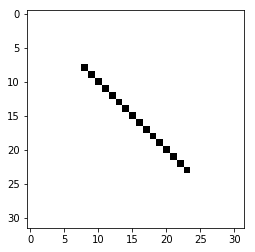

In [88]:
def generate_line(shape):
    line_image = np.ones(shape)
    bound_row = int(line_image.shape[0] / 4)
    bound_col = int(line_image.shape[1] / 2)
    line_image[bound_row:3*bound_row, bound_col, :] = 0
    return line_image

def generate_diagonal(shape):
    line_image = np.ones(shape)
    bound = int(line_image.shape[0] / 4)
    for i in range(bound, bound*3):
        line_image[i, i, :] = 0
    return line_image

print(x_train[1].shape)
line_image = generate_line(x_train[1].shape)
plt.imshow(line_image)

diagonal_image = generate_diagonal(x_train[1].shape)
plt.imshow(diagonal_image)

(3, 3, 3)


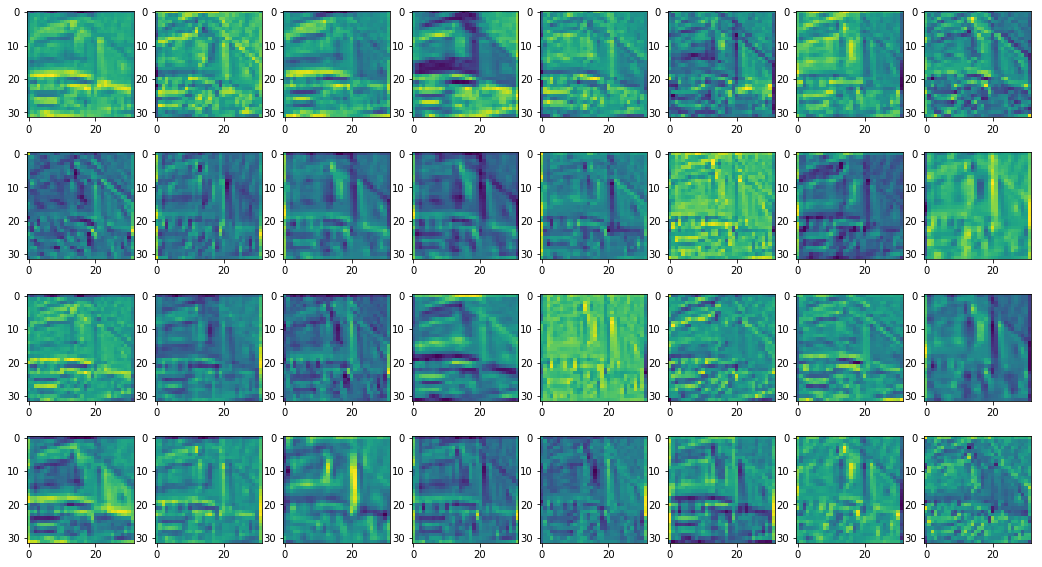

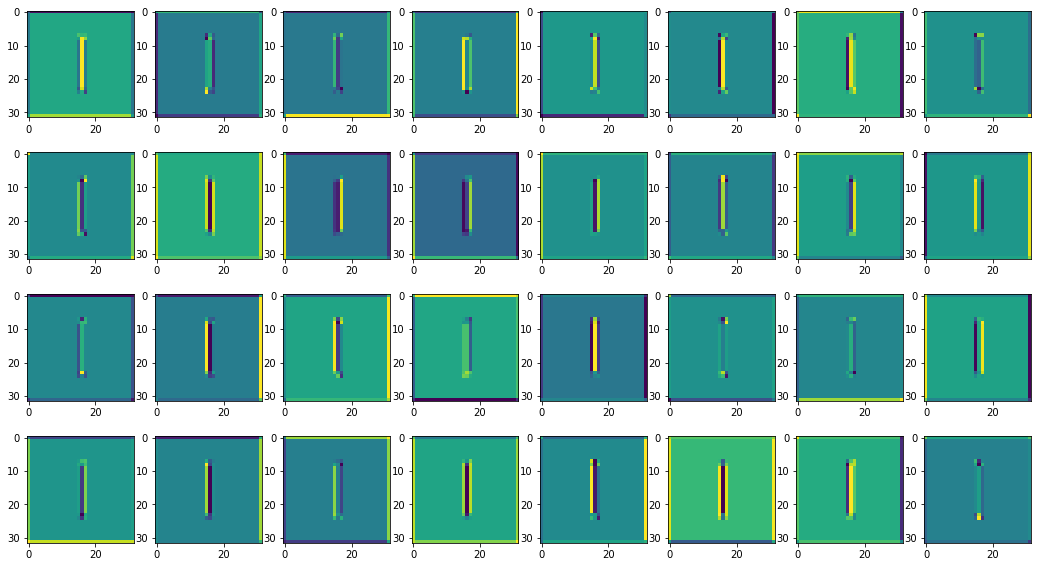

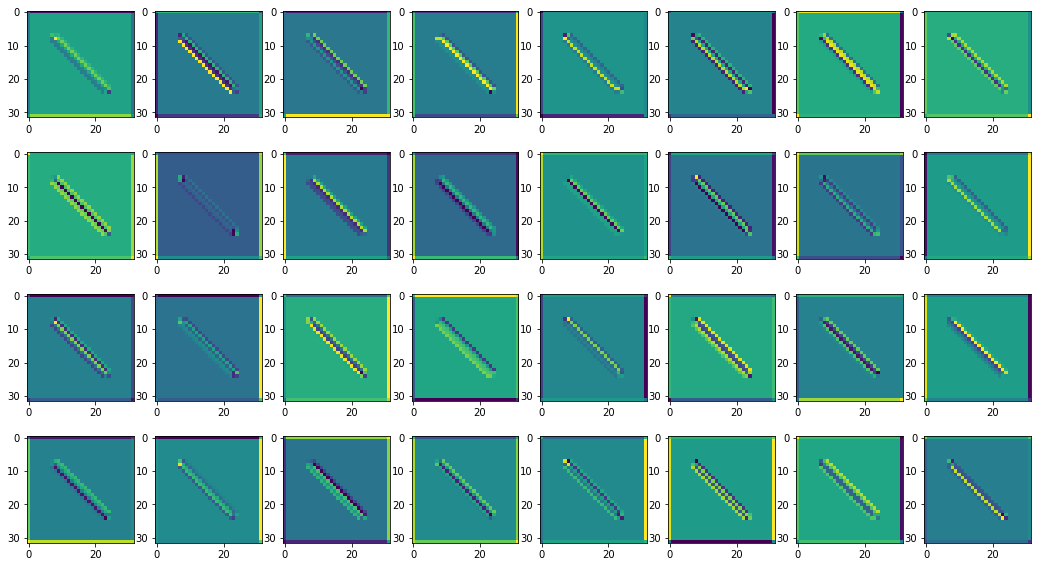

In [92]:
first_layer_output = []
line_output = []
diagonal_output = []

def get_filter(weights, biases, index):
    filter_weights = [weights[i][j][k][index] for i in range(weights.shape[0]) \
                     for j in range(weights.shape[1]) for k in range(weights.shape[2])]
    return np.asarray(filter_weights).reshape((weights.shape[0],weights.shape[1],weights.shape[2])), biases[index]

print(get_filter(conv1_weights, conv1_biases, 0)[0].shape)
    
def generate_padded_noise_image(image, shape):
    # shape = [32, 32, 3] here
#     noise = np.random.normal(size=shape)
    padded_image = np.zeros([shape[0]+2, shape[1]+2, shape[2]])
    padded_image[1:shape[0]+1, 1:shape[1]+1, :] = image
#     plt.imshow(padded_image)
    return padded_image

def filter_mapping(image, filter_weights, filter_bias, x_index, y_index):
#     if padded:
#         x_start = pad + x_index
#         y_start = pad + y_index
#     else:
#         x_start = x_index
#         y_start = y_index
    
    x_start = x_index
    y_start = y_index    
    x_end = x_start + filter_weights.shape[0]
    y_end = y_start + filter_weights.shape[1]
    temp = image[x_start: x_end, y_start: y_end, :]
#     print(temp.shape)
#     print(filter_weights.shape)
#     print(filter_weights.shape)
    summation = np.sum(np.multiply(temp, filter_weights)) + filter_bias
    return summation
    
def trim_padding(image):
    s = image.shape
    unpadded_image = image[2:s[0]-2, 2:s[1]-2, :].copy()
    return unpadded_image 
    
def generate_filter_visualization(image, size, weight, bias, padded=True):
    if padded:
        blank = generate_padded_noise_image(image, size)
    else:
        blank = image
#     print(blank.shape)
    image = [filter_mapping(blank, weight, bias, i, j) for i in range(image.shape[0]) for j in range(image.shape[1])]
    return np.asarray(image).reshape([size[0], size[1]])
    
def draw_visualizations(image, shape, weights, biases, num):
    plt.figure(figsize=(18,10))
    for i in range(weights.shape[3]):
        plt.subplot(4, 8, i+1)
        weight, bias = get_filter(weights, biases, i)
        filter_image = generate_filter_visualization(image, shape, weight, bias)
        if num == 0:
            first_layer_output.append(filter_image)
        elif num == 1:
            line_output.append(filter_image)
        elif num == 2:
            diagonal_output.append(filter_image)
#         print(filter_image.shape)
        plt.imshow(filter_image)

    plt.show()    

# weight, bias = get_filter(conv1_weights, conv1_biases, 0)    
# image = generate_filter_visualization([32, 32, 3], weight, bias)
# plt.imshow(image)
# for i in range(1, 6):
#     print("convolution output for image %d" % i)
#     draw_visualizations(x_train[i],[32, 32, 3], conv1_weights, conv1_biases)
# print(len(first_layer_output))
# first_layer_output
draw_visualizations(x_train[1],[32, 32, 3], conv1_weights, conv1_biases, 0)
draw_visualizations(line_image, [32, 32, 3], conv1_weights, conv1_biases, 1)
draw_visualizations(diagonal_image, [32, 32, 3], conv1_weights, conv1_biases, 2)

In [37]:
def draw_filters(weights, biases):
    plt.figure(figsize=(18,10))
    for i in range(weights.shape[3]):
        plt.subplot(4, 8, i+1)
        weight, bias = get_filter(weights, biases, i)
        plt.imshow(weight)
        
    plt.show()
    
# draw_filters(conv1_weights, conv1_biases)
first_layer_output[0].shape

(32, 32)

In [12]:
print(len(loaded_model.layers[2].get_weights()))
print(loaded_model.layers[2].get_weights()[0].shape)
print(loaded_model.layers[2].get_weights()[1].shape)
conv2_weights = loaded_model.layers[2].get_weights()[0]
conv2_biases = loaded_model.layers[2].get_weights()[1]
loaded_model.layers[2].get_weights()[0]

2
(3, 3, 32, 32)
(32,)


array([[[[ -3.55997123e-02,  -6.23269007e-02,  -2.06237775e-03, ...,
            1.72898266e-02,   3.67610902e-02,  -1.06284574e-01],
         [ -1.00194335e-01,  -2.44629439e-02,  -6.28911471e-03, ...,
            8.18090662e-02,   1.36758424e-02,   6.41113240e-03],
         [ -7.45926574e-02,   9.86085534e-02,  -5.86954392e-02, ...,
           -6.82685152e-02,  -4.51449864e-02,  -1.45536244e-01],
         ..., 
         [  4.73060785e-03,   9.23713073e-02,   9.71762016e-02, ...,
           -3.13120522e-02,   7.11957440e-02,  -6.36577383e-02],
         [ -1.67317316e-02,   4.87031974e-02,   5.41679859e-02, ...,
            7.76505023e-02,  -4.68391366e-02,  -9.98784229e-03],
         [  1.82629246e-02,   1.00327544e-01,  -4.36417609e-02, ...,
           -8.16704333e-03,   6.55494481e-02,   1.00027852e-01]],

        [[ -1.54657185e-01,  -5.04454933e-02,  -9.57127586e-02, ...,
            3.29917856e-02,   2.87193619e-02,   8.95684808e-02],
         [  2.19964907e-02,   1.02985077e-01,

layer1 images


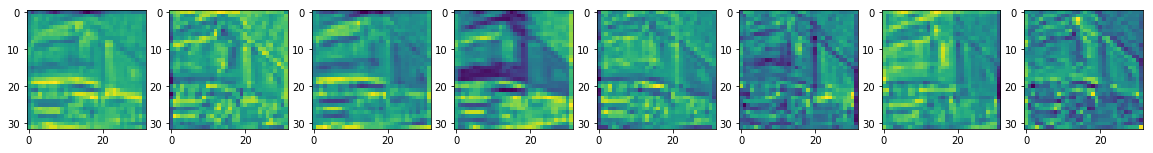

layer2 images


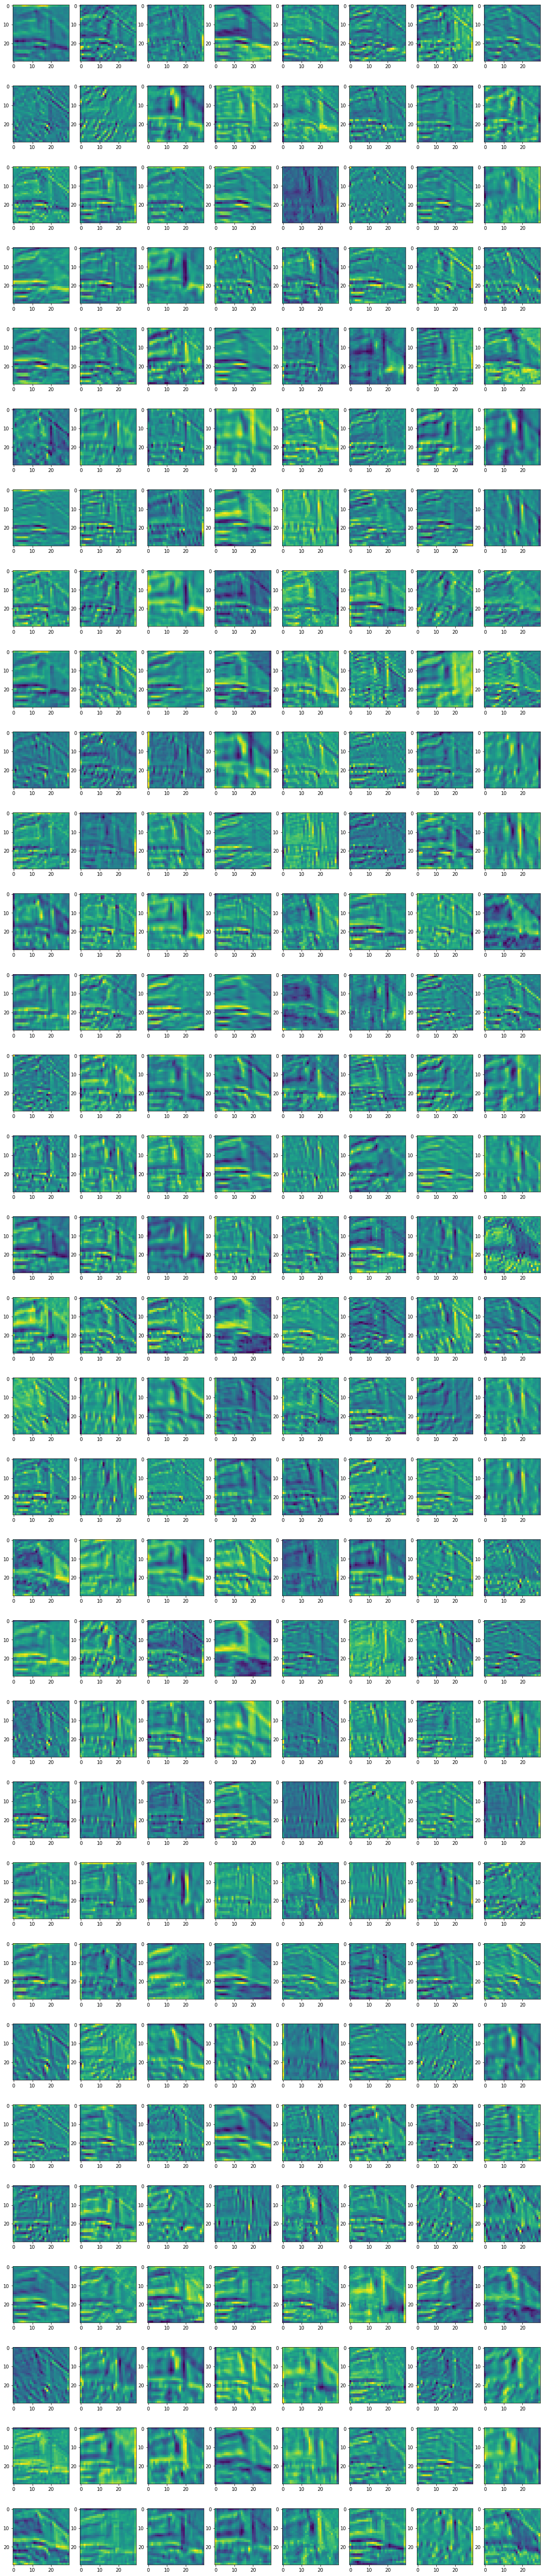

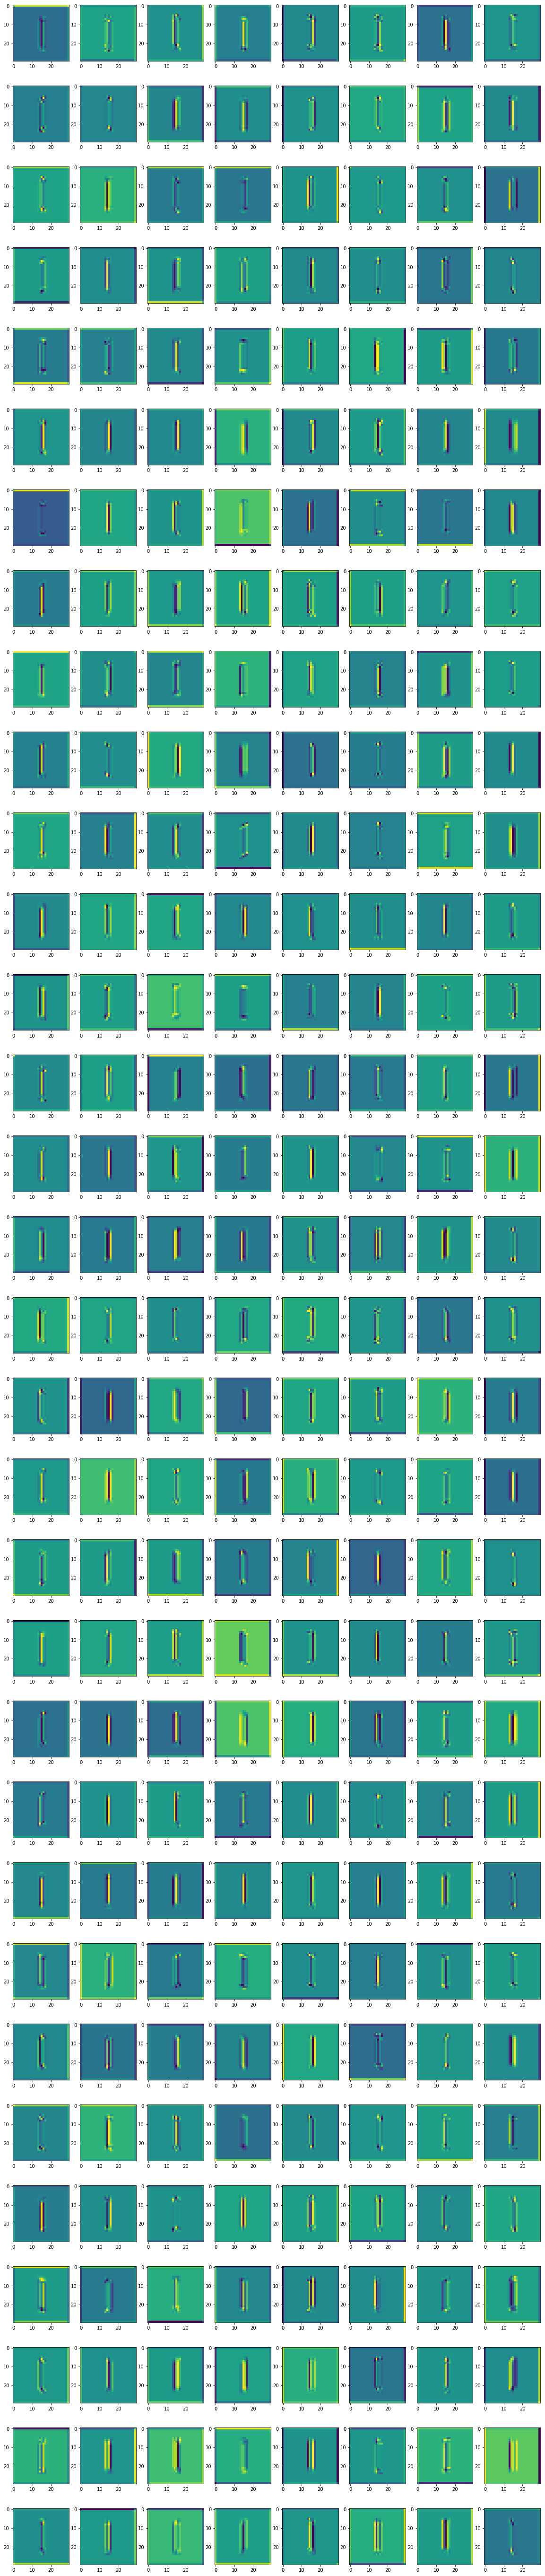

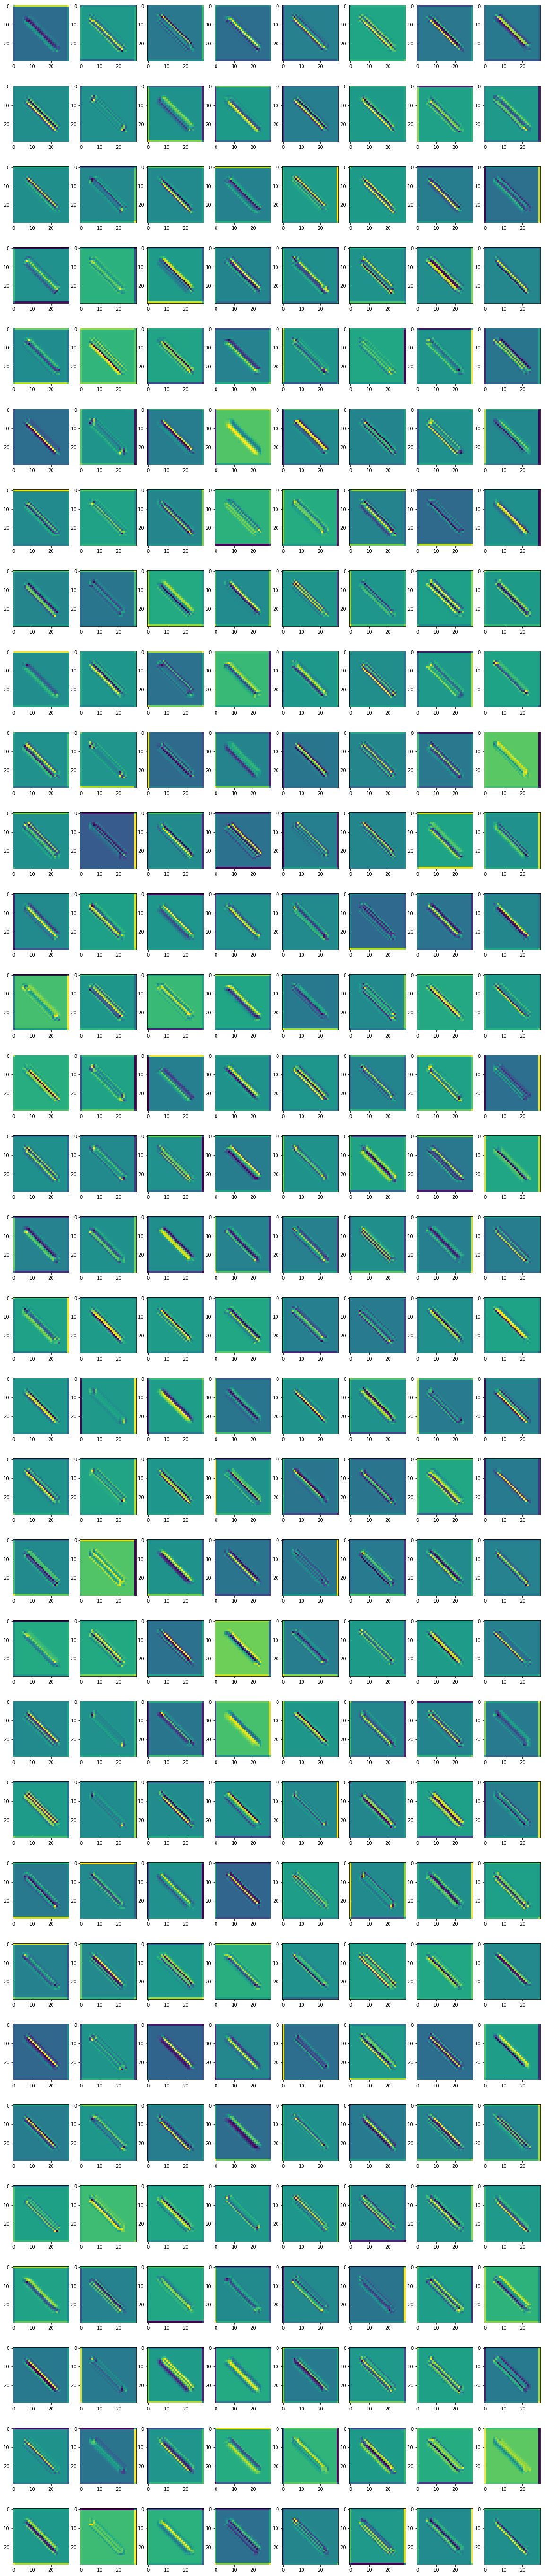

In [93]:
def get_filter_2(weights, biases, index1, index2):
    filter_weights = [weights[i][j][index1][index2] for i in range(weights.shape[0]) \
                     for j in range(weights.shape[1])]
    return np.asarray(filter_weights).reshape((weights.shape[0],weights.shape[1])), biases[index2]

def filter_mapping_2(image, filter_weights, filter_bias, x_index, y_index):
    x_start = x_index
    y_start = y_index    
    x_end = x_start + filter_weights.shape[0]
    y_end = y_start + filter_weights.shape[1]
    temp = image[x_start: x_end, y_start: y_end]

    summation = np.sum(np.multiply(temp, filter_weights)) + filter_bias
    return summation
                                              
                                              
def generate_filter_visualization_2(image, size, weight, bias, padded=True):
    if padded:
        blank = generate_padded_noise_image(image, size)
    else:
        blank = image
#     print(blank.shape)
    image = [filter_mapping_2(blank, weight, bias, i, j) for i in range(image.shape[0]-2) for j in range(image.shape[1]-2)]
    return np.asarray(image).reshape([size[0], size[1]])                                            


def draw_reference(image_input):
    plt.figure(figsize=(20, 6))
    for t in range(8):
        plt.subplot(1, 8, t+1)
        plt.imshow(image_input[t])
    plt.show()

def draw_visualizations_layer2(image_input, shape, weights, biases):
    plt.figure(figsize=(20,100))
    for i in range(weights.shape[3]*8):
        num = i + 1
        plt.subplot(32, 8, num)
        weight, bias = get_filter_2(weights, biases, i%32, int(i/32))
        filter_image = generate_filter_visualization_2(image_input[i%32], shape, weight, bias, padded=False)
        first_layer_output.append(filter_image)
#         print(filter_image.shape)
        plt.imshow(filter_image)

    plt.show()   

print("layer1 images")
draw_reference(first_layer_output)
print("layer2 images")
draw_visualizations_layer2(first_layer_output, [30, 30, 3], conv2_weights, conv2_biases)
draw_visualizations_layer2(line_output, [30, 30, 3], conv2_weights, conv2_biases)
draw_visualizations_layer2(diagonal_output, [30, 30, 3], conv2_weights, conv2_biases)
